## Introduction

Having prepared and cleaned the FIRMS detection-level fire dataset, the next stage of the project is to assess how wildfire activity intersects with environmentally sensitive regions.

This notebook will spatially overlay European fire detection points with protected-area boundaries to examine:

- The extent to which fires occur within protected regions  
- Geographic zones of elevated environmental exposure  
- Regional differences in wildfire impact  

This spatial assessment provides a bridge between exploratory analysis and later predictive modelling.

## Objectives

- Load the cleaned FIRMS fire detection dataset  
- Load European protected-area boundary data  
- Convert fire detections into spatial point objects  
- Perform spatial overlay with protected areas  
- Quantify fire detections occurring within protected zones  
- Visualise spatial relationships between fires and protected regions  

## Contents

1. Load Cleaned Fire Detection Dataset  
2. Load Protected-Area Boundaries  
3. Convert Fire Detections to Spatial Points  
4. Spatial Overlay with Protected Areas  
5. Summary of Fire Exposure in Protected Regions  
6. Spatial Visualisation  
7. Export Overlay Results  
8. Closing Notes  

In [20]:
from pathlib import Path

# Set project root 
PROJECT_DIR = Path.cwd()
if PROJECT_DIR.name == "notebooks":
    PROJECT_DIR = PROJECT_DIR.parent

print("Project root:", PROJECT_DIR)

Project root: c:\Users\Surface\Documents\capstone_project


## 1. Load Cleaned Fire Detection Dataset

The cleaned FIRMS fire detection dataset produced in Notebook 02 is now loaded from the processed data folder.  
This dataset contains detection-level fire points with spatial coordinates and time attributes, prepared for spatial overlay analysis.

In [21]:
import pandas as pd
from pathlib import Path

# Define path to cleaned dataset
processed_path = Path("../data/processed/europe_firms_viirs_snpp_sp_2020_2025_cleaned.csv.gz")

# Load cleaned dataset
fires_clean_df = pd.read_csv(processed_path, compression="gzip")

# Quick confirmation
print("Rows loaded:", len(fires_clean_df))
print("Columns:", fires_clean_df.columns.tolist())

fires_clean_df.head()

Rows loaded: 2680935
Columns: ['latitude', 'longitude', 'bright_ti4', 'scan', 'track', 'acq_date', 'acq_time', 'satellite', 'instrument', 'confidence', 'version', 'bright_ti5', 'frp', 'daynight', 'type', 'query_start_date', 'source', 'bbox', 'acq_time_str', 'acq_datetime', 'year', 'month']


,latitude,longitude,bright_ti4,scan,track,acq_date,acq_time,satellite,instrument,confidence,...,frp,daynight,type,query_start_date,source,bbox,acq_time_str,acq_datetime,year,month
0,58.35962,12.37329,299.82,0.59,0.70,2020-10-01,0,N,VIIRS,n,...,1.05,N,2,2020-10-01,VIIRS_SNPP_SP,"-11,34,31,72",0,2020-10-01 00:00:00,2020,10
1,58.65267,30.28964,296.89,0.44,0.39,2020-10-01,0,N,VIIRS,n,...,0.60,N,0,2020-10-01,VIIRS_SNPP_SP,"-11,34,31,72",0,2020-10-01 00:00:00,2020,10
2,59.06306,28.13327,301.22,0.51,0.41,2020-10-01,0,N,VIIRS,n,...,0.98,N,2,2020-10-01,VIIRS_SNPP_SP,"-11,34,31,72",0,2020-10-01 00:00:00,2020,10
3,59.38455,28.46527,301.06,0.50,0.41,2020-10-01,0,N,VIIRS,n,...,0.94,N,2,2020-10-01,VIIRS_SNPP_SP,"-11,34,31,72",0,2020-10-01 00:00:00,2020,10
4,59.38541,28.45637,295.39,0.50,0.41,2020-10-01,0,N,VIIRS,n,...,0.94,N,0,2020-10-01,VIIRS_SNPP_SP,"-11,34,31,72",0,2020-10-01 00:00:00,2020,10


### Load Confirmation – Observation

- The cleaned fire detection dataset loaded successfully.
- The dataset is ready to be converted into spatial point objects in the next step.

## 2. Load Protected-Area Boundaries

To assess wildfire exposure in environmentally sensitive regions, European protected-area boundary data is now loaded.  

This boundary dataset will later be used to spatially overlay fire detection points and identify which detections occur within protected regions.

A single consistent protected-area boundary dataset is used across the five-year fire detection period, as protected-area designations change slowly over time and a stable boundary layer is standard practice in spatial environmental exposure studies.

In [22]:
import geopandas as gpd
print("GeoPandas version:", gpd.__version__)

GeoPandas version: 1.1.1


In [23]:
import geopandas as gpd
from pathlib import Path

protected_path = Path("../data/raw/protected_areas_europe_polygons.shp")

print("File exists:", protected_path.exists())
protected_areas = gpd.read_file(protected_path)

print("Protected areas loaded:", len(protected_areas))
print("CRS:", protected_areas.crs)
protected_areas.head()

File exists: True
Protected areas loaded: 63049
CRS: EPSG:4326


,SITE_ID,SITE_PID,SITE_TYPE,NAME_ENG,NAME,DESIG,DESIG_ENG,DESIG_TYPE,IUCN_CAT,INT_CRIT,...,MANG_PLAN,VERIF,METADATAID,PRNT_ISO3,ISO3,SUPP_INFO,CONS_OBJ,INLND_WTRS,OECM_ASMT,geometry
0,344,344,PA,Mali i Dajtit,Mali i Dajtit,Park Kombetar,National Park (category II),National,II,Not Applicable,...,Not Reported,State Verified,2013,ALB,ALB,Not Applicable,Not Applicable,Not Reported,Not Applicable,"POLYGON ((19.91936 41.51416, 19.92098 41.51412..."
1,346,346,PA,Mali i Tomorrit,Mali i Tomorrit,Park Kombetar,National Park (category II),National,II,Not Applicable,...,Not Reported,State Verified,2013,ALB,ALB,Not Applicable,Not Applicable,Not Reported,Not Applicable,"POLYGON ((20.21032 40.76819, 20.21015 40.76731..."
2,602,602,PA,Pirin,Pirin,Nacionalen Park,National Park,National,II,Not Applicable,...,Not Reported,State Verified,2013,BGR,BGR,Not Applicable,Not Applicable,Not Reported,Not Applicable,"MULTIPOLYGON (((23.45861 41.81308, 23.45843 41..."
3,603,603,PA,Vitosha,Vitosha,Priroden Park,Nature Park,National,V,Not Applicable,...,Not Reported,State Verified,2013,BGR,BGR,Not Applicable,Not Applicable,Not Reported,Not Applicable,"MULTIPOLYGON (((23.22116 42.65058, 23.22116 42..."
4,604,604,PA,Rusenski Lom,Rusenski Lom,Priroden Park,Nature Park,National,V,Not Applicable,...,Not Reported,State Verified,2013,BGR,BGR,Not Applicable,Not Applicable,Not Reported,Not Applicable,"MULTIPOLYGON (((26.01783 43.61667, 26.01776 43..."


In [24]:
sorted(protected_areas["ISO3"].unique())

['ALB',
 'ALB;MKD',
 'AND',
 'ARM',
 'AUT',
 'AZE',
 'BEL',
 'BGR',
 'BIH',
 'BLR',
 'BLR;POL',
 'CHE',
 'CYP',
 'CZE',
 'DEU',
 'DNK',
 'ESP',
 'ESP;FRA',
 'EST',
 'FIN',
 'FRA',
 'FRA;ITA;MCO',
 'GBR',
 'GEO',
 'GRC',
 'HRV',
 'HUN',
 'HUN;SVK',
 'IRL',
 'ISL',
 'ISR',
 'ITA',
 'JEY',
 'KAZ',
 'KGZ',
 'LIE',
 'LTU',
 'LUX',
 'LVA',
 'MCO',
 'MKD',
 'MLT',
 'MNE',
 'NLD',
 'NOR',
 'POL',
 'PRT',
 'ROU',
 'RUS',
 'SJM',
 'SRB',
 'SVK',
 'SVN',
 'SWE',
 'TJK',
 'TKM',
 'TUR',
 'UKR',
 'UZB']

Some protected-area records contain multiple ISO3 country codes separated by semicolons.  
These represent transboundary protected areas spanning more than one national boundary.  
This is expected in the WDPA dataset and does not indicate a data quality issue.

In [25]:
# Confirm FIRMS coordinate ranges from the actual data
print("FIRMS latitude range:", fires_clean_df["latitude"].min(), "to", fires_clean_df["latitude"].max())
print("FIRMS longitude range:", fires_clean_df["longitude"].min(), "to", fires_clean_df["longitude"].max())

FIRMS latitude range: 34.00017 to 71.6552
FIRMS longitude range: -31.27135 to 40.5


### FIRMS Spatial Extent – Observation

The fire detection dataset spans latitudes 34.00° to 71.65° and longitudes −31.27° to 40.5°.  
This confirms that the extracted FIRMS data fully covers the Europe as intended.

## 4. Convert Fire Detections to Spatial Points

At this point, the fire detection data is still a normal table with latitude and longitude columns.

To carry out spatial analysis, these coordinates are converted into **point geometries** using GeoPandas.  
This creates a GeoDataFrame where each row represents the location of a single fire detection.

Having the fire detections stored as spatial points allows them to be compared with protected-area **polygons** to identify which fires occur inside protected areas.

In [26]:
import geopandas as gpd

# Ensure latitude and longitude are numbers
fires_clean_df["longitude"] = fires_clean_df["longitude"].astype(float)
fires_clean_df["latitude"]  = fires_clean_df["latitude"].astype(float)

fires_gdf = gpd.GeoDataFrame(
    fires_clean_df,
    geometry=gpd.points_from_xy(fires_clean_df["longitude"], fires_clean_df["latitude"]),
    crs="EPSG:4326"
)

print("Number of fire points:", len(fires_gdf))
print("Coordinate system:", fires_gdf.crs)
fires_gdf.head()


Number of fire points: 2680935
Coordinate system: EPSG:4326


,latitude,longitude,bright_ti4,scan,track,acq_date,acq_time,satellite,instrument,confidence,...,daynight,type,query_start_date,source,bbox,acq_time_str,acq_datetime,year,month,geometry
0,58.35962,12.37329,299.82,0.59,0.70,2020-10-01,0,N,VIIRS,n,...,N,2,2020-10-01,VIIRS_SNPP_SP,"-11,34,31,72",0,2020-10-01 00:00:00,2020,10,POINT (12.37329 58.35962)
1,58.65267,30.28964,296.89,0.44,0.39,2020-10-01,0,N,VIIRS,n,...,N,0,2020-10-01,VIIRS_SNPP_SP,"-11,34,31,72",0,2020-10-01 00:00:00,2020,10,POINT (30.28964 58.65267)
2,59.06306,28.13327,301.22,0.51,0.41,2020-10-01,0,N,VIIRS,n,...,N,2,2020-10-01,VIIRS_SNPP_SP,"-11,34,31,72",0,2020-10-01 00:00:00,2020,10,POINT (28.13327 59.06306)
3,59.38455,28.46527,301.06,0.50,0.41,2020-10-01,0,N,VIIRS,n,...,N,2,2020-10-01,VIIRS_SNPP_SP,"-11,34,31,72",0,2020-10-01 00:00:00,2020,10,POINT (28.46527 59.38455)
4,59.38541,28.45637,295.39,0.50,0.41,2020-10-01,0,N,VIIRS,n,...,N,0,2020-10-01,VIIRS_SNPP_SP,"-11,34,31,72",0,2020-10-01 00:00:00,2020,10,POINT (28.45637 59.38541)


### Observation

- Fire detection records were successfully converted into geographic point objects.
- The dataset is now ready for spatial comparison with protected-area polygons.

## 5. Clip Protected Areas to the Europe Study Area

The protected areas dataset covers regions beyond the scope of this project.  
Before comparing fire locations with protected areas, the dataset is reduced to only those sites that fall within the Europe study region.

To do this, a simple **bounding box** is created using the same geographic extent as the FIRMS fire data.  
Protected-area polygons that intersect with this bounding box are kept, while all others are removed.

This step does not identify fires inside protected areas.  
Its purpose is to **reduce the size of the protected areas dataset**, making the next spatial join step faster and more efficient.

In [ ]:
#5.1 Locate Protected Area shape files

from pathlib import Path

# Move up from /notebooks to /capstone_project
PROJECT_ROOT = Path.cwd().parent  
DATA_RAW = PROJECT_ROOT / "data" / "raw"

# Search for protected areas shapefiles
matches = list(DATA_RAW.glob("protected_areas*.shp"))
print("Protected areas shapefiles found:", [m.name for m in matches])

if len(matches) == 1:
    pa_path = matches[0]
else:
    pa_path = DATA_RAW / "protected_areas_europe_polygons.shp"

print("Using protected areas file:", pa_path)
print("File exists:", pa_path.exists())


Protected areas shapefiles found: ['protected_areas_europe_polygons.shp']
Using protected areas file: c:\Users\Surface\Documents\capstone_project\data\raw\protected_areas_europe_polygons.shp
File exists: True


In [36]:
from shapely.geometry import box
from pathlib import Path
import geopandas as gpd

# ---------------------------------------------------------
# Load protected areas (project root -> data/raw)
# ---------------------------------------------------------
PROJECT_ROOT = Path.cwd().parent
DATA_RAW = PROJECT_ROOT / "data" / "raw"

protected_gdf = gpd.read_file(DATA_RAW / "protected_areas_europe_polygons.shp")

# ---------------------------------------------------------
# Ensure protected areas use the same CRS as fire points
# ---------------------------------------------------------
protected_gdf = protected_gdf.to_crs(fires_gdf.crs)

# ---------------------------------------------------------
# Clip protected areas to the Europe study bounding box
# ---------------------------------------------------------
# Bounding box format: box(west, south, east, north)
europe_bbox = box(-31.5, 34, 40.5, 72)

protected_clip = protected_gdf[protected_gdf.intersects(europe_bbox)].copy()

# ---------------------------------------------------------
# Quick confirmation
# ---------------------------------------------------------
print("Protected areas before clipping:", len(protected_gdf))
print("Protected areas after clipping:", len(protected_clip))

protected_clip.head()


Protected areas before clipping: 63049
Protected areas after clipping: 62408


,SITE_ID,SITE_PID,SITE_TYPE,NAME_ENG,NAME,DESIG,DESIG_ENG,DESIG_TYPE,IUCN_CAT,INT_CRIT,...,MANG_PLAN,VERIF,METADATAID,PRNT_ISO3,ISO3,SUPP_INFO,CONS_OBJ,INLND_WTRS,OECM_ASMT,geometry
0,344,344,PA,Mali i Dajtit,Mali i Dajtit,Park Kombetar,National Park (category II),National,II,Not Applicable,...,Not Reported,State Verified,2013,ALB,ALB,Not Applicable,Not Applicable,Not Reported,Not Applicable,"POLYGON ((19.91936 41.51416, 19.92098 41.51412..."
1,346,346,PA,Mali i Tomorrit,Mali i Tomorrit,Park Kombetar,National Park (category II),National,II,Not Applicable,...,Not Reported,State Verified,2013,ALB,ALB,Not Applicable,Not Applicable,Not Reported,Not Applicable,"POLYGON ((20.21032 40.76819, 20.21015 40.76731..."
2,602,602,PA,Pirin,Pirin,Nacionalen Park,National Park,National,II,Not Applicable,...,Not Reported,State Verified,2013,BGR,BGR,Not Applicable,Not Applicable,Not Reported,Not Applicable,"MULTIPOLYGON (((23.45861 41.81308, 23.45843 41..."
3,603,603,PA,Vitosha,Vitosha,Priroden Park,Nature Park,National,V,Not Applicable,...,Not Reported,State Verified,2013,BGR,BGR,Not Applicable,Not Applicable,Not Reported,Not Applicable,"MULTIPOLYGON (((23.22116 42.65058, 23.22116 42..."
4,604,604,PA,Rusenski Lom,Rusenski Lom,Priroden Park,Nature Park,National,V,Not Applicable,...,Not Reported,State Verified,2013,BGR,BGR,Not Applicable,Not Applicable,Not Reported,Not Applicable,"MULTIPOLYGON (((26.01783 43.61667, 26.01776 43..."


### Observation

- Protected-area polygons were successfully clipped to the fire detection study region.
- This reduces processing overhead and ensures spatial overlay is applied only where fire data exists.

## 6. Identify Fire Detections Inside Protected Areas

With both datasets prepared as spatial layers, the next step is to identify which fire detection points fall inside protected-area polygons.

Before performing the spatial join, the available columns in the clipped protected areas dataset are reviewed.

In [38]:
protected_clip.columns

Index(['SITE_ID', 'SITE_PID', 'SITE_TYPE', 'NAME_ENG', 'NAME', 'DESIG',
       'DESIG_ENG', 'DESIG_TYPE', 'IUCN_CAT', 'INT_CRIT', 'REALM',
       'REP_M_AREA', 'GIS_M_AREA', 'REP_AREA', 'GIS_AREA', 'NO_TAKE',
       'NO_TK_AREA', 'STATUS', 'STATUS_YR', 'GOV_TYPE', 'GOVSUBTYPE',
       'OWN_TYPE', 'OWNSUBTYPE', 'MANG_AUTH', 'MANG_PLAN', 'VERIF',
       'METADATAID', 'PRNT_ISO3', 'ISO3', 'SUPP_INFO', 'CONS_OBJ',
       'INLND_WTRS', 'OECM_ASMT', 'geometry'],
      dtype='object')

### Rationale for Protected Area Columns Included in the Spatial Join

The spatial join links each fire detection point to a protected-area polygon.  
Because this join is computationally expensive on a large dataset, only columns that are needed for later analysis are carried forward.

The selected fields are included for the following reasons:

- **`SITE_ID`**  
  Used as the primary unique identifier for each protected area. This supports grouping, summarising fire activity by site, and reliable linking to any future protected-area lookups.

- **`ISO3`**  
  Provides a consistent country code for country-level summaries and dashboard views (e.g. top countries by protected-area fire detections).

- **`IUCN_CAT`**  
  Indicates the protection category/strictness. This supports comparisons of fire activity across protection levels and may be useful as an explanatory feature in modelling.

- **`DESIG_ENG`**  
  A readable designation label (e.g. National Park, Nature Reserve). This improves interpretability in outputs and dashboards.

- **`REALM`**  
  Adds broad ecological context (e.g. terrestrial vs marine), which is useful when interpreting fire presence and when comparing patterns across different landscape types.

- **`STATUS`** and **`STATUS_YR`**  
  Provide designation status and year. These fields support context checks (e.g. whether an area was officially designated during the study period) and allow for optional time-aware analysis.

- **`NO_TAKE`** (and/or **`NO_TK_AREA`** if required)  
  Represents stricter protection rules. This can support deeper comparisons of fire activity across different management/protection regimes.

- **`geometry`**  
  Required for the spatial join itself, as it defines the protected-area boundaries used in the point-in-polygon check.

Keeping only these fields reduces memory usage while preserving the most relevant identifiers and context needed for protected-area analysis, biodiversity overlay interpretation, and potential predictive feature engineering.

In [41]:
# ---------------------------------------------------------
# Perform spatial join: keep only fire points inside protected areas
# ---------------------------------------------------------

pa_cols = [
    "geometry",
    "SITE_ID",
    "ISO3",
    "IUCN_CAT",
    "DESIG_ENG",
    "REALM",
    "STATUS",
    "STATUS_YR",
    "NO_TAKE"
]

fires_in_protected = gpd.sjoin(
    fires_gdf,                    # Fire detection points
    protected_clip[pa_cols],      # Selected protected-area attributes
    how="inner",                  # Keep only matching records
    predicate="within"            # Point must fall inside polygon
)

# ---------------------------------------------------------
# Quick confirmation of spatial join
# ---------------------------------------------------------
print("Total fire detections:", len(fires_gdf))
print("Fire detections inside protected areas:", len(fires_in_protected))

# ---------------------------------------------------------
# Calculate percentage of fires occurring in protected areas
# ---------------------------------------------------------
total_fires = len(fires_gdf)
fires_in_pa = len(fires_in_protected)
percentage_in_pa = (fires_in_pa / total_fires) * 100

print(f"Percentage of fires in protected areas: {percentage_in_pa:.2f}%")

fires_in_protected.head()


Total fire detections: 2680935
Fire detections inside protected areas: 165166
Percentage of fires in protected areas: 6.16%


,latitude,longitude,bright_ti4,scan,track,acq_date,acq_time,satellite,instrument,confidence,...,geometry,index_right,SITE_ID,ISO3,IUCN_CAT,DESIG_ENG,REALM,STATUS,STATUS_YR,NO_TAKE
28,45.35933,29.60139,305.97,0.38,0.36,2020-10-01,4,N,VIIRS,n,...,POINT (29.60139 45.35933),3940,68147,ROU,Not Reported,Wetland of International Importance (Ramsar Site),Coastal,Designated,1991,Not Reported
29,45.36011,29.59653,313.01,0.38,0.36,2020-10-01,4,N,VIIRS,n,...,POINT (29.59653 45.36011),3940,68147,ROU,Not Reported,Wetland of International Importance (Ramsar Site),Coastal,Designated,1991,Not Reported
82,38.79569,15.20942,305.86,0.37,0.58,2020-10-01,6,N,VIIRS,n,...,POINT (15.20942 38.79569),3447,63133,ITA,IV,Regional/Provincial Nature Reserve,Coastal,Designated,1997,Not Reported
83,38.79624,15.19967,309.38,0.37,0.58,2020-10-01,6,N,VIIRS,n,...,POINT (15.19967 38.79624),3447,63133,ITA,IV,Regional/Provincial Nature Reserve,Coastal,Designated,1997,Not Reported
182,38.50055,-8.93949,298.71,0.63,0.54,2020-10-01,147,N,VIIRS,n,...,POINT (-8.93949 38.50055),102,1340,PRT,V,Nature Park,Coastal,Designated,1976,Not Reported


> ### Observation
>  
> Over the full European study period, **6.16% of all detected fire events occurred within protected areas**.  
>  
> Although the majority of fire detections fall outside protected boundaries, this finding indicates that protected areas are not immune to fire activity. The presence of fire detections within designated conservation sites supports further investigation into spatial, temporal, and environmental factors influencing wildfire occurrence in protected landscapes.

## 7. Fire Detections in Protected Areas by Country

To understand how wildfire exposure varies geographically, fire detections inside protected areas are summarised by country using the ISO3 country codes provided in the WDPA dataset.

In [45]:
# Top 10 countries by fire detections inside protected areas
top10_pa_countries = fires_in_protected["ISO3"].value_counts().head(10)

print("Top 10 countries by fire detections inside protected areas:")
top10_pa_countries

Top 10 countries by fire detections inside protected areas:


ISO3
ITA    24770
ROU    22986
ESP    22692
GRC    18638
UKR    18106
GBR    13604
FRA    11404
PRT     8822
RUS     5401
ALB     3206
Name: count, dtype: int64

In [46]:
# Top 10 countries by number of fires in protected areas
top10_pa_countries = fires_in_protected["ISO3"].value_counts().head(10)

# Convert to percentage share of protected-area fires (top 10 only)
top10_pa_percentage = (top10_pa_countries / top10_pa_countries.sum()) * 100

top10_pa_percentage.round(2)

ISO3
ITA    16.55
ROU    15.36
ESP    15.17
GRC    12.46
UKR    12.10
GBR     9.09
FRA     7.62
PRT     5.90
RUS     3.61
ALB     2.14
Name: count, dtype: float64

> ### Observation
> The highest counts of fire detections within protected areas are concentrated in a small number of countries.  
> Based on the current results, **Italy (ITA), Romania (ROU), Spain (ESP), Greece (GRC), and Ukraine (UKR)** record the largest numbers of protected-area fire detections, followed by **the United Kingdom (GBR), France (FRA), Portugal (PRT), Russia (RUS), and Albania (ALB)**.  

> When expressed as a share of all fire detections occurring within protected areas, Italy, Romania, and Spain each account for approximately **15–17%** of protected-area fire detections, with Greece and Ukraine also contributing substantial shares.  
>  
> Together, the top five countries represent over **70%** of all fire detections recorded within protected areas, indicating a strong geographic concentration of protected-area fire activity across Europe.

> This ranking will be used as a starting point for deeper analysis (e.g. comparisons by protection category and designation type) and to guide which countries may be most useful to highlight in dashboard outputs.

## 8. Visual Check of Spatial Overlay

A simple map is created to visually confirm that fire detection points align correctly with protected-area boundaries.

Protected-area boundaries are shown as outlines, with fire detections occurring inside protected areas overlaid as points.  
This step acts as a visual validation of the spatial join before proceeding with further analysis.

<Axes: >

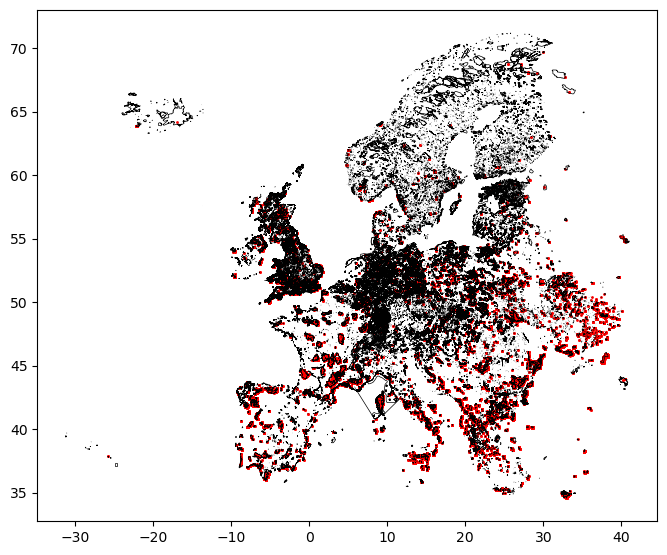

In [47]:
# Visual check: protected areas and fire detections inside them
ax = protected_clip.boundary.plot(
    figsize=(8, 8),
    linewidth=0.5,
    color="black"
)

fires_in_protected.plot(
    ax=ax,
    color="red",
    markersize=1
)

## Notebook Summary and Next Steps

This notebook completed the spatial analysis linking European wildfire detection data with protected-area boundaries.

Fire detection records were converted from latitude–longitude coordinates into spatial point geometries and aligned to a consistent coordinate reference system.  
Protected-area polygons were loaded, reprojected, and clipped to the European study region to improve efficiency and ensure spatial consistency.

A spatial join was applied to identify fire detections occurring within protected areas, with a targeted selection of protected-area attributes retained to support robust downstream analysis.  
The proportion of European fire detections affecting protected areas was quantified, and country-level summaries were produced to highlight geographic concentration patterns.  
A visual overlay map was also used to validate the spatial alignment and results of the spatial join.

The next logical step is to integrate biodiversity data and analyse wildfire detections, protected areas, and species-related indicators together in a single analytical framework.  
This combined dataset will enable a more robust assessment of ecological risk and will form the basis for feature engineering and predictive modelling to estimate future wildfire exposure in European protected areas.